<a href="https://colab.research.google.com/github/macrae/comics-net/blob/master/jupyter/fastai_entity_removal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Comic Book Cover Restoration?

Image restoration is the process of restoring the original image from the distorted one. Image restoration is of various kinds like:

- take a low-resolution image and convert it to the high-resolution image
- convert the black and white image to the coloured image
- restore the broken part of the image

We will focus this research spike on restoring the broken part of the image.

In [422]:
import fastai
import pathlib
from fastai.vision import *
from fastai.callbacks import *
from fastai.vision.gan import *
from PIL import Image, ImageDraw, ImageFont

In [423]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [424]:
path = pathlib.Path.cwd()
# path_hr = path/'gdrive/My Drive/covers/justice_league/images'
# path_lr = path/'gdrive/My Drive/covers/justice_league/crappy'
# path/'gdrive/My Drive/covers/'

In [425]:
# !rm -rf "/content/images"

In [426]:
# !cp -rf "/content/gdrive/My Drive/covers" "/content/covers"

In [427]:
# !tar -xvf "/content/covers/justice_league/images.tar.gz" -C "/content/covers/justice_league"

In [428]:
path = pathlib.Path.cwd().parent

path_images = path/'covers/justice_league/images'
path_images_crappy = path/'covers/justice_league/crappy'

path_sans_barcodes = path/'covers/justice_league/images_sans_barcodes'
path_barcoded = path/'covers/justice_league/barcoded'
barcode = path/'covers/justice_league/barcode.png'

In [429]:
from PIL import Image 
    
def crop_barcode(img_path, dest):

    # Opens a image in RGB mode 
    im = Image.open(img_path)

    # Size of the image in pixels (size of orginal image) 
    # (This is not mandatory) 
    width, height = im.size 

    # Setting the points for cropped image 
    left = 0
    top = 0
    right = 400
    bottom = int(600 * .8)

    # Cropped image of above dimension 
    # (It will not change orginal image) 
    im1 = im.crop((left, top, right, bottom)) 

    # Shows the 
    im1.save(dest)

In [368]:
from os import listdir
from os.path import isfile, join
onlyfiles = [f for f in listdir(path_images) if isfile(join(path_images, f))]

In [366]:
for file in onlyfiles:
    crop_barcode(str(path_images) + "/" + file, str(path_sans_barcodes) + "/" + file)

In [430]:
class barcodify(object):
    
    def __init__(self, path_sans_barcodes, path_barcodes, barcode):
        self.path_sans_barcodes = path_sans_barcodes
        self.path_barcodes = path_barcodes
        self.barcode = barcode
    
    def __call__(self, path, i):
        dest = self.path_barcodes/path.name
        dest.parent.mkdir(parents=True, exist_ok=True)
        
        img = PIL.Image.open(path)
        img_w, img_h = img.size
        
        barcode_open = PIL.Image.open(self.barcode)
        targ_sz = resize_to(barcode_open, (60), use_min=True)
        barcode = barcode_open.resize(targ_sz, resample=PIL.Image.BILINEAR).convert('RGB')
        barcode_w, barcode_h = barcode.size

        offset_w, offset_h = random.randint(0, img_w - barcode_w), random.randint(0, img_h - barcode_h)
        
        offset = (offset_w, offset_h)
        img.paste(barcode, offset)
        img.save(dest)

In [431]:
# barcoder = barcodify(path_sans_barcodes, path_barcoded, path_barcode)

# barcoder(il.items[0], 0)

In [432]:
barcoder = barcodify(path_sans_barcodes, path_barcoded, path_barcode)

il = ImageList.from_folder(path_sans_barcodes)
parallel(barcoder, il.items)

In [10]:
# class crappifier(object):
#     def __init__(self, path_lr, path_hr):
#         self.path_lr = path_lr
#         self.path_hr = path_hr
#     def __call__(self, fn, i):
#         dest = self.path_lr/fn.relative_to(self.path_hr)
#         dest.parent.mkdir(parents=True, exist_ok=True)
#         img_open = PIL.Image.open(fn)
#         targ_sz = resize_to(img_open, 96, use_min=True)
#         img = img_open.resize(targ_sz, resample=PIL.Image.BILINEAR).convert('RGB')
#         w,h = img.size
#         q = random.randint(10,70)
#         ImageDraw.\
#           Draw(img).\
#           text((random.randint(0,w//2),random.randint(0,h//2)), str(q), fill=(255,255,255))
#         img.save(dest, quality=q)

Memorize one thing, anything you do not include in the crappifier() , the model won’t learn to fix that.

The process to crappify the images can take a while, but fast.ai has a function called parallel. If you pass parallel a function name and a list of things to run that function on, it will run that function on them all in parallel. So, it will save a lot of time.

In [9]:
# crappify = crappifier(path_lr, path_hr)

# il = ImageList.from_folder(path_hr)
# parallel(crappify, il.items)

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.functional")

bs, size = 32, (600//6, 400//6)
arch = models.resnet34
src = ImageImageList.from_folder(path_lr).split_by_rand_pct(0.1, seed=42)
def get_data(bs,size):
    data = (src.label_from_func(lambda x: path_hr/x.name)
               .transform(size=size, tfm_y=True)
               .databunch(bs=bs).normalize(imagenet_stats, do_y=True))
    
    return data

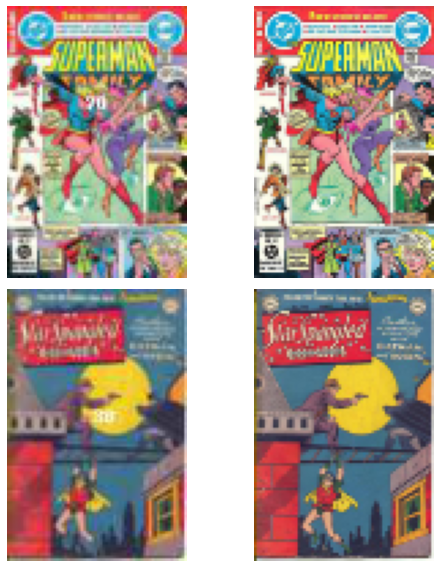

In [11]:
data_gen = get_data(bs,size)
data_gen.show_batch(2)

In [12]:
wd = 1e-3
y_range = (-3.,3.)
loss_gen = MSELossFlat()
def create_gen_learner():
    return unet_learner(data_gen,
                        arch, wd=wd,
                        blur=True,
                        norm_type=NormType.Weight,
                        self_attention=True,
                        y_range=y_range,
                        loss_func=loss_gen)

learn_gen = create_gen_learner()

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [13]:
learn_gen.fit_one_cycle(2, pct_start=0.8)

epoch,train_loss,valid_loss,time
0,0.120859,0.122958,01:41
1,0.106420,0.104949,01:39


epoch,train_loss,valid_loss,time
0,0.101995,0.101595,01:45
1,0.099466,0.099547,01:42
2,0.098120,0.098685,01:43


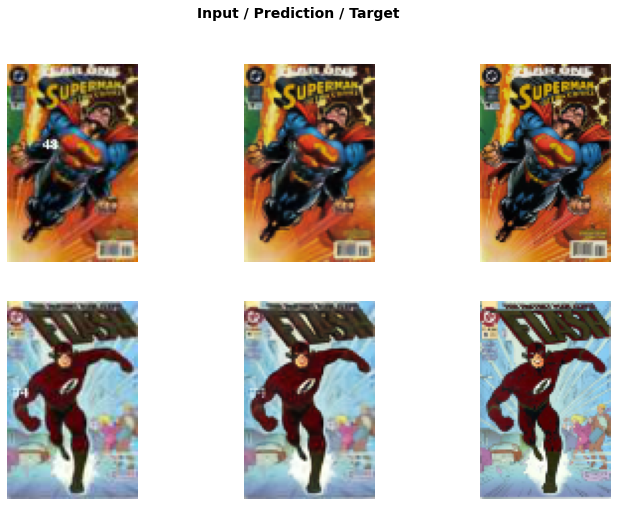

In [14]:
learn_gen.unfreeze()
learn_gen.fit_one_cycle(3, slice(1e-6,1e-3))
learn_gen.show_results(rows=2)

In [ ]:
name_gen = "covers/justice_league/image_gen"
path_gen = path/name_gen
path_gen.mkdir(exist_ok=True)

In [ ]:
# # list path_gen
# !ls "/content/covers/justice_league/image_gen"

In [ ]:
def save_preds(dl):
    i=0
    names = dl.dataset.items
    
    for b in dl:
        preds = learn_gen.pred_batch(batch=b, reconstruct=True)
        for o in preds:
            o.save(path_gen/names[i].name)
            i += 1

save_preds(data_gen.fix_dl)

In [ ]:
# path
# name_gen

In [ ]:
def get_crit_data(classes, bs, size):
    src = ImageList.from_folder(path/'covers/justice_league/', include=classes)\
                   .split_by_rand_pct(0.1, seed=42)
  
    ll = src.label_from_folder(classes=classes)
    data = (ll.transform(get_transforms(max_zoom=2.), size=size)
              .databunch(bs=bs).normalize(imagenet_stats))
    return data

data_crit = get_crit_data(['image_gen', 'images'], bs=bs, size=size)

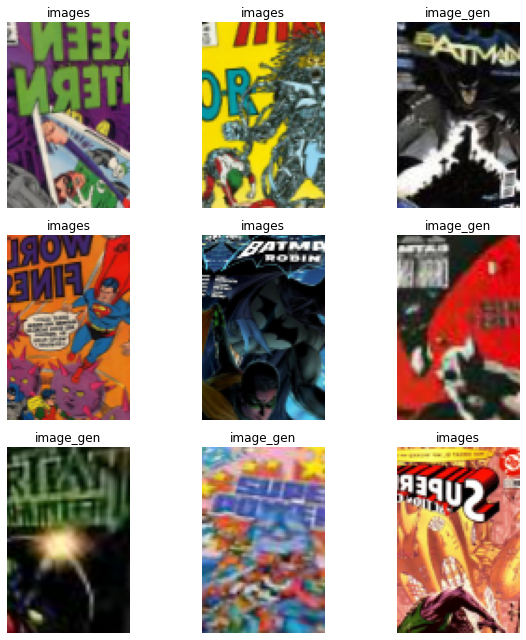

In [20]:
data_crit.show_batch(rows=3, ds_type=DatasetType.Train, imgsize=3)

In [ ]:
loss_critic = AdaptiveLoss(nn.BCEWithLogitsLoss())

def create_critic_learner(data, metrics):
    return Learner(data, gan_critic(), metrics=metrics, loss_func=loss_critic, wd=wd)

learn_critic = create_critic_learner(data_crit, accuracy_thresh_expand)

In [22]:
learn_critic.fit_one_cycle(6, 1e-3)

epoch,train_loss,valid_loss,accuracy_thresh_expand,time
0,0.476158,0.839866,0.582205,02:12
1,0.183626,0.212457,0.910885,02:12
2,0.065965,0.135350,0.942329,02:12
3,0.046621,0.037642,0.988579,02:11
4,0.021134,0.016459,0.994924,02:10
5,0.015310,0.019389,0.993796,02:10


In [ ]:
learn_crit=None
learn_gen=None
data_crit = get_crit_data(['crappy', 'images'], bs=bs, size=size)

learn_crit = create_critic_learner(data_crit, metrics=None)
learn_gen = create_gen_learner()

In [ ]:
switcher = partial(AdaptiveGANSwitcher, critic_thresh=0.65)

learn = GANLearner.from_learners(learn_gen, 
                                 learn_crit, 
                                 weights_gen=(1.,50.),        
                                 show_img=False, 
                                 switcher=switcher,    
                                 opt_func=partial(optim.Adam, betas=(0.,0.99)), wd=wd)

learn.callback_fns.append(partial(GANDiscriminativeLR, mult_lr=5.))

In [25]:
lr = 1e-4
learn.fit(40,lr)

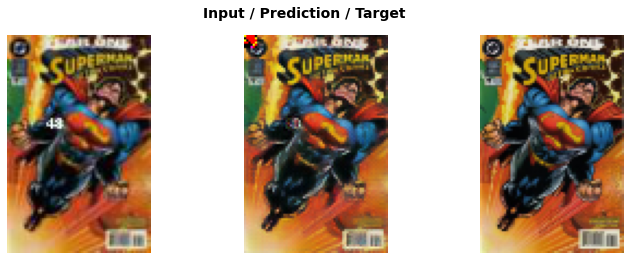

In [26]:
learn.show_results(rows=1)